# Import Packages

In [ ]:
!pip install -U sentence-transformers
!pip install umap-learn
!pip install pyamg

     |████████████████████████████████| 71kB 3.1MB/s 
     |████████████████████████████████| 1.1MB 14.0MB/s 
     |████████████████████████████████| 890kB 38.2MB/s 
     |████████████████████████████████| 1.1MB 44.6MB/s 
     |████████████████████████████████| 3.0MB 53.5MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.8-cp36-none-any.whl size=101996 sha256=a62984ed6415dabf9fedd13957dbda56c73860a901a938c482d23b63fa06057e
  Stored in directory: /root/.cache/pip/wheels/27/ec/b3/d12cc8e4daf77846db6543033d3a5642f204c0320b15945647
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=cd6744c86e75272dfd5a948ea7ea39cb7bf2e99e5f1a323f170ddd78cc117b63
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses
     |████████████████████████████████| 6.4MB 3.2MB/s 
     |████████████████████████████████| 194kB 44.2MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
import string
import re

# Import Data and Preprocessing

In [ ]:
from sklearn.datasets import fetch_20newsgroups

In [ ]:
# import data 20news from sklearn 
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=('headers', 'footers', 'quotes'),
                                      random_state=42)
# transform into dataframe the text and the targets
df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
df.columns = ['text', 'target']
# transform into dataframe the categories
targets = pd.DataFrame( newsgroups_train.target_names)
targets.columns=['category']
# merge the both
data_train = pd.merge(df, targets, left_on='target', right_index=True)
# keep only the text and the titlcategoryes associated
data_train.reset_index(inplace=True)
data_train.drop(['index', 'target'], axis=1, inplace=True)
# modify the dataframe for getting a sub categories (5 levels of categories)
data_train.category = data_train.category.apply(lambda t: t.split('.'))
data_train.category = data_train.category.apply(lambda t: t+['none' for i in range(5-len(t))])
s = data_train.category
dd = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
dd.columns = ['sub_cat_0', 'sub_cat_1', 'sub_cat_2', 'sub_cat_3', 'sub_cat_4']
data_train = pd.concat([data_train, dd], axis=1)

# import data 20news from sklearn 
newsgroups_train = fetch_20newsgroups(subset='test', 
                                      remove=('headers', 'footers', 'quotes'),
                                      random_state=42)
# transform into dataframe the text and the targets
df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
df.columns = ['text', 'target']
# transform into dataframe the categories
targets = pd.DataFrame( newsgroups_train.target_names)
targets.columns=['category']
# merge the both
data_test = pd.merge(df, targets, left_on='target', right_index=True)
# keep only the text and the titlcategoryes associated
data_test.reset_index(inplace=True)
data_test.drop(['index', 'target'], axis=1, inplace=True)
# modify the dataframe for getting a sub categories (5 levels of categories)
data_test.category = data_test.category.apply(lambda t: t.split('.'))
data_test.category = data_test.category.apply(lambda t: t+['none' for i in range(5-len(t))])
s = data_test.category
dd = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
dd.columns = ['sub_cat_0', 'sub_cat_1', 'sub_cat_2', 'sub_cat_3', 'sub_cat_4']
data_test = pd.concat([data_test, dd], axis=1)

In [ ]:
data_train

,text,category,sub_cat_0,sub_cat_1,sub_cat_2,sub_cat_3,sub_cat_4
0,I was wondering if anyone out there could enli...,"[rec, autos, none, none, none]",rec,autos,none,none,none
1,I recently posted an article asking what kind ...,"[rec, autos, none, none, none]",rec,autos,none,none,none
2,\nIt depends on your priorities. A lot of peo...,"[rec, autos, none, none, none]",rec,autos,none,none,none
3,an excellent automatic can be found in the sub...,"[rec, autos, none, none, none]",rec,autos,none,none,none
4,: Ford and his automobile. I need information...,"[rec, autos, none, none, none]",rec,autos,none,none,none
...,...,...,...,...,...,...,...
11309,Secrecy in Clipper Chip\n\nThe serial number o...,"[sci, crypt, none, none, none]",sci,crypt,none,none,none
11310,Hi !\n\nI am interested in the source of FEAL ...,"[sci, crypt, none, none, none]",sci,crypt,none,none,none
11311,"The actual algorithm is classified, however, t...","[sci, crypt, none, none, none]",sci,crypt,none,none,none
11312,\n\tThis appears to be generic calling upon th...,"[sci, crypt, none, none, none]",sci,crypt,none,none,none


# EDA

## Sub Cat 0 - Pie graph

We want to observe the distribution of the principale category

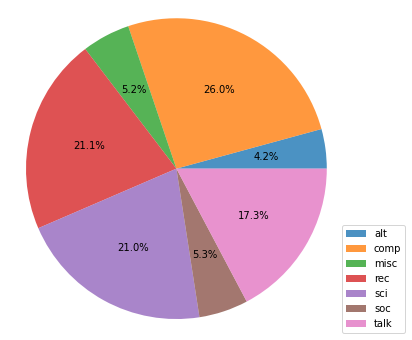

In [ ]:
figure = plt.figure(figsize=(6, 6))

sc0, sizes = np.unique(data_train.sub_cat_0, return_counts=True)
#sc0_names = [data_train.sub_cat_0.values[i] for i in sc0]

patches, _, _ = plt.pie(sizes, autopct='%1.1f%%', wedgeprops={'alpha': 0.8})

plt.legend(patches, sc0, loc=(1, 0.0))

plt.axis('equal')
plt.show()

We notice that categories COMP, SCI, REC and TALK are +/- equally represented. Whereas categories MISC, ALT, SOC are slighlty represented.

We can assume that some statistics of the documents are different according to the category.

## Zipf Law

In [ ]:
# https://en.wikipedia.org/wiki/Zipf%27s_law

def zipfs_law(texts,
               low_outlier_percentile_bound=1,
               upper_outlier_percentile_bound=99):

    counter = Counter(' '.join(texts).split())
    frequencies = [freq for word, freq in counter.most_common()]
    low_outlier_bound = np.percentile(frequencies, low_outlier_percentile_bound)
    upper_outlier_bound = np.percentile(frequencies, upper_outlier_percentile_bound)
    frequencies = [freq for freq in frequencies if freq > low_outlier_bound and freq <= upper_outlier_bound]
    ranks = range(1, len(frequencies) + 1)

    return ranks , frequencies

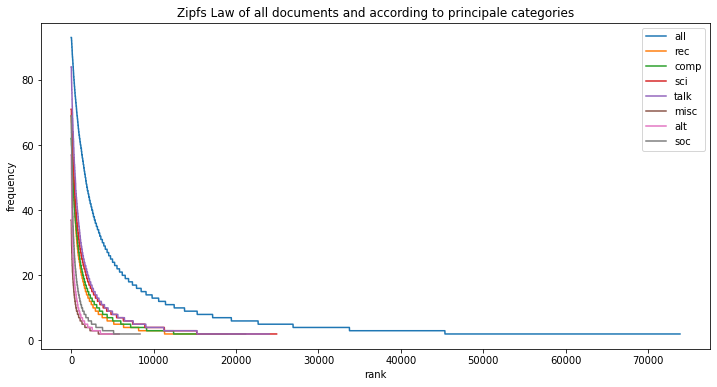

In [ ]:
plt.figure(figsize=(12,6))
for cat in ['all']+data_train.sub_cat_0.unique().tolist():
  if cat=='all':
    all_doc = data_train.text.values.tolist()
    r_all, f_all = zipfs_law(all_doc)
    plt.plot(r_all, f_all, label='all')
  else:
    sc0_doc = data_train[data_train.sub_cat_0==cat].text.values.tolist()
    r_cat, f_cat = zipfs_law(sc0_doc)
    plt.plot(r_cat, f_cat, label=cat)
plt.legend()
plt.title("Zipfs Law of all documents and according to principale categories")
plt.xlabel('rank')
plt.ylabel('frequency')
plt.show()

## Heaps Law

In [ ]:
def heaps_law(texts):
  lengths = [len(t.split()) for t in texts]
  num_uniques = [len(set(t.split())) for t in texts]
  return lengths, num_uniques

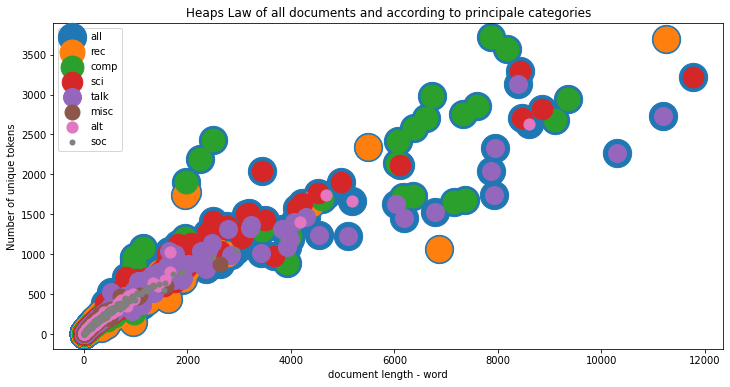

In [ ]:
plt.figure(figsize=(12,6))

for i, cat in enumerate(['all']+data_train.sub_cat_0.unique().tolist()):
  if cat=='all':
    all_doc = data_train.text.values.tolist()
    r_all, f_all = heaps_law(all_doc)
    plt.scatter(r_all, f_all, label='all', s=800 - i*100)
  else:
    sc0_doc = data_train[data_train.sub_cat_0==cat].text.values.tolist()
    r_cat, f_cat = heaps_law(sc0_doc)
    plt.scatter(r_cat, f_cat, label=cat, s=800-(i+0.75)*100)
plt.legend()
plt.title("Heaps Law of all documents and according to principale categories")
plt.xlabel('document length - word')
plt.ylabel('Number of unique tokens')
plt.show()

## Histogram of documents lengths

In [ ]:
def lengths_histogram(texts,
                      low_outlier_percentile_bound=1,
                      upper_outlier_percentile_bound=99):
  
    lengths = [len(t.split()) for t in texts]
    low_outlier_bound = np.percentile(lengths, low_outlier_percentile_bound)
    upper_outlier_bound = np.percentile(lengths, upper_outlier_percentile_bound)
    lengths = [l for l in lengths if l > low_outlier_bound and l <= upper_outlier_bound]
    return lengths

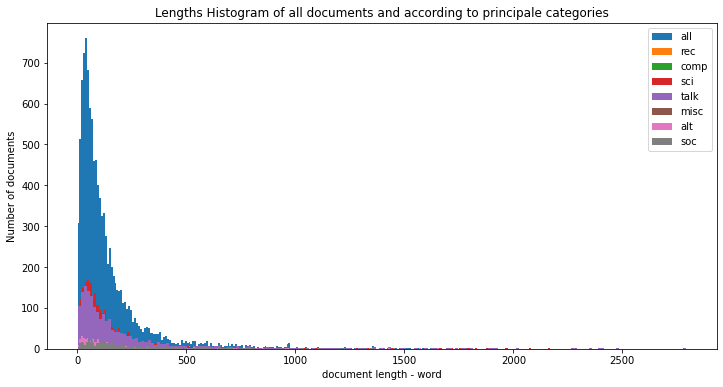

In [ ]:
plt.figure(figsize=(12,6))

for i, cat in enumerate(['all']+data_train.sub_cat_0.unique().tolist()):
  if cat=='all':
    all_doc = data_train.text.values.tolist()
    r_all = lengths_histogram(all_doc)
    plt.hist(r_all, label='all', bins=200)
  else:
    sc0_doc = data_train[data_train.sub_cat_0==cat].text.values.tolist()
    r_cat= lengths_histogram(sc0_doc)
    plt.hist(r_cat, label=cat, bins=200)
plt.legend()
plt.title("Lengths Histogram of all documents and according to principale categories")
plt.xlabel('document length - word')
plt.ylabel('Number of documents')
plt.show()

## Relation between each sub categories

In [ ]:
for cat in ['sub_cat_0', 'sub_cat_1', 'sub_cat_2', 'sub_cat_3', 'sub_cat_4']:
  s = data_train[cat].value_counts()
  plt.bar(s.index, s.values/s.sum())
  plt.xticks(rotation=45)
  plt.xlabel(cat)
  plt.ylabel('Probability')
  plt.title(r'Histogram of '+ cat)
  plt.show()

In [ ]:
col = ['sub_cat_0','sub_cat_1','sub_cat_2','sub_cat_3','sub_cat_4']
df_cat = data_train[col]
targets = []
for cat in col:
  targets = targets + [t for t in df_cat[cat].unique().tolist()]
tragets = list(set(targets))

n = len(targets)
mat_corr_cat = np.zeros((n, n))
dict_cat = {}
for row in df_cat.itertuples():
  print(row.sub_cat_0)
  break

rec


In [ ]:
df_cat.groupby(df_cat.columns.tolist()).size().reset_index()

,sub_cat_0,sub_cat_1,sub_cat_2,sub_cat_3,sub_cat_4,0
0,alt,atheism,none,none,none,480
1,comp,graphics,none,none,none,584
2,comp,os,ms-windows,misc,none,591
3,comp,sys,ibm,pc,hardware,590
4,comp,sys,mac,hardware,none,578
5,comp,windows,x,none,none,593
6,misc,forsale,none,none,none,585
7,rec,autos,none,none,none,594
8,rec,motorcycles,none,none,none,598
9,rec,sport,baseball,none,none,597


In [ ]:
(pd.crosstab(df_cat.sub_cat_0, df_cat.sub_cat_1).T/df_cat.groupby('sub_cat_0').size().values).T

sub_cat_1,atheism,autos,crypt,electronics,forsale,graphics,med,motorcycles,os,politics,religion,space,sport,sys,windows
sub_cat_0,,,,,,,,,,,,,,,
alt,1.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
comp,0.0,0.00000,0.000000,0.000000,0.0,0.19891,0.000000,0.000000,0.201294,0.000000,0.000000,0.000000,0.000000,0.39782,0.201975
misc,0.0,0.00000,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
rec,0.0,0.24864,0.000000,0.000000,0.0,0.00000,0.000000,0.250314,0.000000,0.000000,0.000000,0.000000,0.501046,0.00000,0.000000
sci,0.0,0.00000,0.250737,0.249052,0.0,0.00000,0.250316,0.000000,0.000000,0.000000,0.000000,0.249895,0.000000,0.00000,0.000000
soc,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
talk,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.806865,0.193135,0.000000,0.000000,0.00000,0.000000


In [ ]:




from sklearn.mixture import GaussianMixture as GMM

from sklearn.cluster import SpectralClustering


from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, SpectralEmbedding
from umap import UMAP

# Corpus extraction

In [ ]:
corpus = data_train.text.values.tolist()

# Topic extraction with NMF and LDA

In [ ]:
from time import time
import random
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [ ]:
n_samples = 2000
n_features = 1000
n_components = 7
n_top_words = 10


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.



In [ ]:
random.shuffle(corpus)
corpus_samples = corpus[:n_samples]

In [ ]:
# Use tf-idf features
print("Extracting tf-idf features...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
                                   min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(corpus_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features.
print("Extracting tf ...")
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(corpus_samples)
print("done in %0.3fs." % (time() - t0))
print()


Extracting tf-idf features...
done in 0.288s.
Extracting tf ...
done in 0.278s.



In [ ]:

# Fit the NMF model with Frobenius norm and tfidf
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model with Kullback-Leiber and tfidf
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)



Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.174s.

Topics in NMF model (Frobenius norm):
Topic #0: don just think like people good time make know ve
Topic #1: windows file use dos drive files using card memory color
Topic #2: god jesus bible believe christians church christ sin son faith
Topic #3: thanks does know advance mail hi looking address information info
Topic #4: 00 sale shipping list 50 cover price new 10 sold
Topic #5: edu soon university email mail condition cs hope subject sale
Topic #6: team game players games season year hockey play teams player

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.843s.

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: just like don think ve way time did good right
Topic #1: windows use drive file using software card thanks files problem
Topic #2: god believe jesus bibl

In [ ]:
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model with tf:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

print("Fitting LDA models with tfidf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model with tfidf:")
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)

Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 2.889s.

Topics in LDA model with tf:
Topic #0: 00 file output entry 000 oname program printf stream char
Topic #1: file jpeg gif image information use files internet images mail
Topic #2: output gun file program entry firearms line function use number
Topic #3: key space chip encryption data use time des team clipper
Topic #4: edu drive thanks bit use windows like os mac does
Topic #5: god jesus 10 son church 11 period bible 17 13
Topic #6: people don just like think know time good say right

Fitting LDA models with tfidf features, n_samples=2000 and n_features=1000...
done in 1.249s.

Topics in LDA model with tfidf:
Topic #0: 1993 sold journal march season 1992 00 com 49 just
Topic #1: null waiting char states int misc tape filename entry format
Topic #2: just don like know think does thanks use good ve
Topic #3: laws values year universe short probe 23 message april moon
Topic #4: plus supposed cars p

# Vector Embedding with SBERT

In [ ]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:25<00:00, 15.9MB/s]


In [ ]:
corpus_embeddings = embedder.encode(corpus)

In [ ]:
corpus_embeddings.shape

(11314, 768)

## Similarity Matrix

In [ ]:
#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.pytorch_cos_sim(corpus_embeddings, corpus_embeddings)

In [ ]:
cosine_scores = cosine_scores.numpy()

# Apply clustering on full vectors

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

## KMeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
num_clusters = 7

km = KMeans(n_clusters=num_clusters)

km.fit(corpus_embeddings)

clusters = km.labels_.tolist()

data_train['km_clusters'] = clusters

ari = adjusted_rand_score(data_train.sub_cat_0, data_train.km_clusters)

nmi = normalized_mutual_info_score(data_train.sub_cat_0, data_train.km_clusters)

print(ari, nmi)

0.1302882310395798 0.17809941980448996


## Agglomerative clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
agg.labels_

array([6635, 8479, 9922, ...,    1,    2,    0])

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
for aff in ['euclidean', 'l1', 'l2', 'manhattan']:
    for link in ['ward', 'average', 'complete']:
      if aff!='euclidean' and link=='ward':
        print(aff, link)
        print('impossible')
      else:
        agg = AgglomerativeClustering(n_clusters=7, affinity=aff, linkage=link)

        agg = agg.fit(corpus_embeddings)

        data_train['agg_clusters'] = agg.labels_

        ari = adjusted_rand_score(data_train.sub_cat_0, data_train.agg_clusters)

        nmi = normalized_mutual_info_score(data_train.sub_cat_0, data_train.agg_clusters)

        print(aff, link)
        print(ari, nmi)

euclidean ward
0.19144568632578837 0.2409081337709689
euclidean average
-0.0006575701589842411 0.002981751485590231
euclidean complete
0.025472941831154672 0.06167431303958115
l1 ward
impossible
l1 average
-0.0009567860099416667 0.002948794350936495
l1 complete
0.09948557433791409 0.12468524452712536
l2 ward
impossible
l2 average
-0.0006575701589842411 0.002981751485590231
l2 complete
0.025472941831154672 0.06167431303958115
manhattan ward
impossible
manhattan average
-0.0009567860099416667 0.002948794350936495
manhattan complete
0.09948557433791409 0.12468524452712536


In [ ]:
for aff in ['cosine', 'precomputed']:
    for link in ['average', 'complete']:
      if aff=='cosine':
        agg = AgglomerativeClustering(n_clusters=7, affinity=aff, linkage=link)

        agg = agg.fit(corpus_embeddings)

        data_train['agg_clusters'] = agg.labels_

        ari = adjusted_rand_score(data_train.sub_cat_0, data_train.agg_clusters)

        nmi = normalized_mutual_info_score(data_train.sub_cat_0, data_train.agg_clusters)

        print(aff, link)
        print(ari, nmi)
      elif aff=='precomputed':
        agg = AgglomerativeClustering(n_clusters=7, affinity=aff, linkage=link)

        agg = agg.fit(cosine_scores)

        data_train['agg_clusters'] = agg.labels_

        ari = adjusted_rand_score(data_train.sub_cat_0, data_train.agg_clusters)

        nmi = normalized_mutual_info_score(data_train.sub_cat_0, data_train.agg_clusters)

        print(aff, link)
        print(ari, nmi)

cosine average
-0.0006543166069725377 0.0040901780729402995
cosine complete
0.06921899866160866 0.07197441517841613
precomputed average
-7.959203899269908e-05 0.0009966398653774703
precomputed complete
0.0005509397491578703 0.0007947498226673375


'ward'

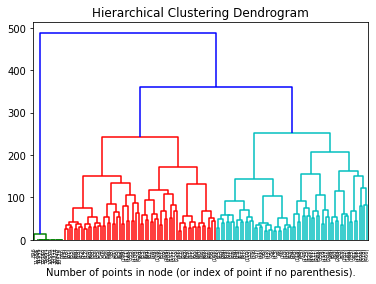

In [ ]:
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
agg = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
agg.fit(corpus_embeddings)

data_train['agg_clusters'] = agg.labels_
ari = adjusted_rand_score(data_train.sub_cat_0, data_train.agg_clusters)
nmi = normalized_mutual_info_score(data_train.sub_cat_0, data_train.agg_clusters)

In [ ]:

data_train.agg_clusters.value_counts()


0    2631
2    2381
1    2177
6    1990
4    1017
5     817
3     301
Name: agg_clusters, dtype: int64

In [ ]:
pd.crosstab(data_train.agg_clusters, data_train.sub_cat_0)

sub_cat_0,alt,comp,misc,rec,sci,soc,talk
agg_clusters,,,,,,,
0,33,441,386,803,780,34,154
1,286,120,20,184,422,441,704
2,5,1859,115,66,301,9,26
3,12,71,8,84,61,8,57
4,35,366,31,198,198,32,157
5,3,5,1,768,10,0,30
6,106,74,24,286,601,75,824


In [ ]:
data_train[(data_train.sub_cat_0=='sci')].agg_clusters.value_counts()

0    780
6    601
1    422
2    301
4    198
3     61
5     10
Name: agg_clusters, dtype: int64

# DimRed Solutions

## Multidimensional Scaling

In [ ]:
from sklearn.manifold import MDS

In [ ]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(1-cosine_scores)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


NameError: ignored

In [ ]:
cosine_scores

array([[1.0000001 , 0.7160857 , 0.6191044 , ..., 0.5360776 , 0.48640186,
        0.24551722],
       [0.7160857 , 0.9999999 , 0.6699708 , ..., 0.44181615, 0.5142851 ,
        0.25923854],
       [0.6191044 , 0.6699708 , 1.        , ..., 0.6019724 , 0.616187  ,
        0.4251931 ],
       ...,
       [0.53607756, 0.44181612, 0.6019724 , ..., 0.99999887, 0.63822997,
        0.36323553],
       [0.4864017 , 0.5142851 , 0.61618686, ..., 0.63822985, 0.9999997 ,
        0.3190789 ],
       [0.2455172 , 0.25923848, 0.42519313, ..., 0.36323547, 0.3190789 ,
        0.9999998 ]], dtype=float32)

In [ ]:
a = data_train["sub_cat_0"].astype('category')
plt.scatter(x=xs, y=ys, c=a.cat.codes,s=1, cmap='Spectral')
plt.show()

NameError: ignored

## UMAP Application

In [ ]:
umap = UMAP(n_components=2, metric='cosine', n_neighbors=100, min_dist=0)

NameError: ignored

In [ ]:
X_umap = umap.fit_transform(X_scale)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [ ]:
X_umap.shape

(11270, 2)

In [ ]:
11270/7

1610.0

In [ ]:
a = data_train["sub_cat_0"].astype('category')
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=a.cat.codes,s=1, cmap='Spectral')
plt.show()

## PCA

In [ ]:
pca = PCA()
pca.fit(X_scale)
pca_variance = np.cumsum(pca.explained_variance_ratio_)

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(range(len(pca_variance)), pca_variance, alpha=0.5, align='center', label='Cumulative Sum variance ratio')
plt.legend()
plt.ylabel('Cumulative Sum Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [ ]:
pca = PCA(400)
X_pca = pca.fit_transform(X_scale) 

# Clustering Methods

## Spectral Clustering



In [ ]:
from sklearn.cluster import SpectralClustering
import pyamg

In [ ]:
spectral_cluter = SpectralClustering(n_clusters=7, eigen_solver='amg').fit(X_scale[:1000])

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: ignored